In [55]:
#general imports that we will need will almost always use - it is a good practice to import all libraries at the beginning of the notebook or script
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

# ignore warnings
import warnings
warnings.filterwarnings('ignore')



%run functions.py

df_train = pd.read_csv("project_data/train.csv", delimiter=',', header=0, decimal='.', quotechar='"')

X_train_selected = pd.read_csv("X_train_selected.csv", delimiter=',', header=0, decimal='.', quotechar='"')
y_train = pd.read_csv("y_train.csv", delimiter=',', header=0, decimal='.', quotechar='"')
X_val_selected = pd.read_csv("X_val_selected.csv", delimiter=',', header=0, decimal='.', quotechar='"')
y_val = pd.read_csv("y_val.csv", delimiter=',', header=0, decimal='.', quotechar='"')
X_test_selected = pd.read_csv("X_test_selected.csv", delimiter=',', header=0, decimal='.', quotechar='"')
X_val = pd.read_csv("X_val.csv", delimiter=',', header=0, decimal='.', quotechar='"')
X_train = pd.read_csv("X_train.csv", delimiter=',', header=0, decimal='.', quotechar='"')

#set random seed for reproducibility
RSEED = 42
np.random.seed(RSEED)


In [56]:
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

In [57]:
#STEP 1 - Add back 'Brand' and 'model' columns to selected datasets for brand-specific modeling
X_train_with_brand = X_train_selected.copy()
X_train_with_brand['Brand'] = X_train['Brand'].values  # brand original
X_train_with_brand_with_model = X_train_with_brand.copy()
X_train_with_brand_with_model['model'] = X_train['model'].values

X_val_with_brand = X_val_selected.copy()
X_val_with_brand['Brand'] = X_val['Brand'].values
X_val_with_brand_with_model = X_val_with_brand.copy()
X_val_with_brand_with_model['model'] = X_val['model'].values

In [58]:
"""
GENERAL vs BRAND/MODEL-SPECIFIC MODELS COMPARISON
==================================================
Test whether better performance is achieved using a general model or specific models
"""


# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def compute_metrics(y_true, y_pred, label=""):
    """Compute comprehensive metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    return {
        'label': label,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'mape': mape,
        'n_samples': len(y_true)
    }



In [59]:

# ============================================================================
# MAIN ANALYSIS FUNCTIONS
# ============================================================================

def train_general_model(X_train, y_train, X_val, y_val, model_params=None):
    """
    Train a single general model on all data
    """
    print("="*80)
    print("TRAINING GENERAL MODEL (All Brands/Models)")
    print("="*80)
    
    if model_params is None:
        model_params = {
            'learning_rate': 0.01,
            'max_depth': 15,
            'max_leaf_nodes': 511,
            'min_samples_leaf': 1,
            'l2_regularization': 0.05,
            'max_iter': 1500,
            'random_state': 42,
            'early_stopping': True,
            'validation_fraction': 0.1
        }
    
    model = HistGradientBoostingRegressor(**model_params)
    model.fit(X_train, y_train)
    
    # Predictions
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    
    # Metrics
    train_metrics = compute_metrics(y_train, train_pred, "General - Train")
    val_metrics = compute_metrics(y_val, val_pred, "General - Val")
    
    print(f"\nGeneral Model Performance:")
    print(f"  Train: MAE={train_metrics['mae']:.2f}, R²={train_metrics['r2']:.4f}")
    print(f"  Val:   MAE={val_metrics['mae']:.2f}, R²={val_metrics['r2']:.4f}")
    print(f"  Samples: Train={len(y_train)}, Val={len(y_val)}")
    
    return model, train_metrics, val_metrics



In [60]:

def train_brand_specific_models(X_train, y_train, X_val, y_val, 
                                  brand_column='brand', model_params=None,
                                  min_samples=50, apply_scaling=False,
                                  categorical_features=None, use_raw_data=False):
    """
    Train separate models for each brand
    
    Parameters:
    -----------
    apply_scaling : bool
        If True, apply StandardScaler to features (useful for neural networks)
        If False, no scaling (recommended for tree-based models)
    categorical_features : list or 'auto'
        List of categorical feature names or 'auto' to detect automatically
        Only works with HistGradientBoostingRegressor
    use_raw_data : bool
        If True, assumes data has NOT been encoded yet (categorical columns as strings/objects)
        If False, assumes data is already encoded (numerical)
    """
    print("\n" + "="*80)
    print("TRAINING BRAND-SPECIFIC MODELS")
    print("="*80)
    
    # Check if brand column exists (case-insensitive)
    brand_col_found = None
    for col in X_train.columns:
        if col.lower() == brand_column.lower():
            brand_col_found = col
            break
    
    if brand_col_found is None:
        print(f"ERROR: Column '{brand_column}' not found in data!")
        print(f"Available columns: {X_train.columns.tolist()}")
        print(f"\nColumns with 'brand' in name: {[c for c in X_train.columns if 'brand' in c.lower()]}")
        return None, None
    
    # Use the correct column name
    brand_column = brand_col_found
    print(f"Using column: '{brand_column}'")
    
    if model_params is None:
        model_params = {
            'learning_rate': 0.01,
            'max_depth': 12,
            'max_leaf_nodes': 255,
            'min_samples_leaf': 1,
            'l2_regularization': 0.05,
            'max_iter': 1000,
            'random_state': 42,
            'early_stopping': True,
            'validation_fraction': 0.1
        }
    
    # Get brands
    train_brands = X_train[brand_column].value_counts()
    print(f"\nBrands in training data: {len(train_brands)}")
    print(f"Filtering brands with at least {min_samples} samples...")
    
    valid_brands = train_brands[train_brands >= min_samples].index.tolist()
    print(f"Valid brands for specific models: {len(valid_brands)}")
    
    if apply_scaling:
        print("Note: Scaling will be applied per brand")
    
    brand_models = {}
    brand_scalers = {}
    brand_metrics = []
    
    for brand in valid_brands:
        # Filter data for this brand
        train_mask = X_train[brand_column] == brand
        val_mask = X_val[brand_column] == brand
        
        X_train_brand = X_train[train_mask].drop(columns=[brand_column])
        y_train_brand = y_train[train_mask]
        X_val_brand = X_val[val_mask].drop(columns=[brand_column])
        y_val_brand = y_val[val_mask]
        
        # Apply scaling if requested
        if apply_scaling:
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            X_train_brand = pd.DataFrame(
                scaler.fit_transform(X_train_brand),
                columns=X_train_brand.columns,
                index=X_train_brand.index
            )
            X_val_brand = pd.DataFrame(
                scaler.transform(X_val_brand),
                columns=X_val_brand.columns,
                index=X_val_brand.index
            )
            brand_scalers[brand] = scaler
        
        if len(X_val_brand) == 0:
            print(f"  {brand:20s}: SKIP - No validation samples")
            continue
        
        # Train model
        try:
            model = HistGradientBoostingRegressor(**model_params)
            model.fit(X_train_brand, y_train_brand)
            
            # Predictions
            train_pred = model.predict(X_train_brand)
            val_pred = model.predict(X_val_brand)
            
            # Metrics
            train_metrics = compute_metrics(y_train_brand, train_pred, f"{brand} - Train")
            val_metrics = compute_metrics(y_val_brand, val_pred, f"{brand} - Val")
            
            brand_models[brand] = model
            brand_metrics.append(val_metrics)
            
            print(f"  {brand:20s}: Train MAE={train_metrics['mae']:7.2f}, Val MAE={val_metrics['mae']:7.2f}, "
                  f"R²={val_metrics['r2']:.3f}, n_train={len(y_train_brand):4d}, n_val={len(y_val_brand):3d}")
        
        except Exception as e:
            print(f"  {brand:20s}: ERROR - {str(e)}")
    
    return brand_models, pd.DataFrame(brand_metrics)



In [61]:

def train_model_specific_models(X_train, y_train, X_val, y_val,
                                  model_column='model', min_samples=30):
    """
    Train separate models for each car model (brand + model combination)
    """
    print("\n" + "="*80)
    print("TRAINING MODEL-SPECIFIC MODELS")
    print("="*80)
    
    if model_column not in X_train.columns:
        print(f"ERROR: Column '{model_column}' not found in data!")
        return None
    
    # Get models
    train_models = X_train[model_column].value_counts()
    print(f"\nModels in training data: {len(train_models)}")
    print(f"Filtering models with at least {min_samples} samples...")
    
    valid_models = train_models[train_models >= min_samples].index.tolist()
    print(f"Valid models for specific models: {len(valid_models)}")
    
    model_specific = {}
    model_metrics = []
    
    model_params = {
        'learning_rate': 0.01,
        'max_depth': 10,
        'max_leaf_nodes': 127,
        'min_samples_leaf': 1,
        'l2_regularization': 0.08,
        'max_iter': 800,
        'random_state': 42,
        'early_stopping': True,
        'validation_fraction': 0.1
    }
    
    for model_name in valid_models[:20]:  # Limit to top 20 for speed
        # Filter data
        train_mask = X_train[model_column] == model_name
        val_mask = X_val[model_column] == model_name
        
        X_train_model = X_train[train_mask].drop(columns=[model_column])
        y_train_model = y_train[train_mask]
        X_val_model = X_val[val_mask].drop(columns=[model_column])
        y_val_model = y_val[val_mask]
        
        if len(X_val_model) == 0:
            continue
        
        try:
            model = HistGradientBoostingRegressor(**model_params)
            model.fit(X_train_model, y_train_model)
            
            val_pred = model.predict(X_val_model)
            val_metrics = compute_metrics(y_val_model, val_pred, f"{model_name} - Val")
            
            model_specific[model_name] = model
            model_metrics.append(val_metrics)
            
            print(f"  {model_name[:30]:30s}: Val MAE={val_metrics['mae']:7.2f}, "
                  f"R²={val_metrics['r2']:.3f}, n_val={len(y_val_model):3d}")
        
        except Exception as e:
            print(f"  {model_name[:30]:30s}: ERROR - {str(e)}")
    
    return model_specific, pd.DataFrame(model_metrics)



In [62]:

def compare_approaches(general_model, brand_models, X_train, X_val, y_train, y_val,
                        brand_column='brand', general_model_has_brand=False,
                        use_general_for_missing_brands=True):
    """
    Compare general model vs brand-specific models on the same validation data
    
    Parameters:
    -----------
    general_model_has_brand : bool
        If True, general model was trained WITH brand column
        If False, general model was trained WITHOUT brand column (needs to drop it)
    use_general_for_missing_brands : bool
        If True, use general model for brands that don't have specific models
        If False, skip those brands in brand-specific evaluation
    """
    print("\n" + "="*80)
    print("COMPARING GENERAL vs BRAND-SPECIFIC APPROACHES")
    print("="*80)
    
    results = []
    
    # General model on all validation data
    if general_model_has_brand:
        # General model expects brand column
        general_pred = general_model.predict(X_val)
    else:
        # General model was trained without brand, need to drop it
        X_val_no_brand = X_val.drop(columns=[brand_column])
        general_pred = general_model.predict(X_val_no_brand)
    
    general_metrics = compute_metrics(y_val, general_pred, "General Model")
    results.append(general_metrics)
    
    print(f"\nGeneral Model (all validation data):")
    print(f"  MAE: {general_metrics['mae']:.2f}")
    print(f"  R²: {general_metrics['r2']:.4f}")
    print(f"  Samples: {general_metrics['n_samples']}")
    
    # Brand-specific models combined
    brand_predictions = []
    brand_actuals = []
    brands_processed = []
    brands_skipped = []
    brands_using_general = []
    
    print("\nProcessing brand-specific predictions:")
    
    # Get all unique brands in validation
    all_val_brands = X_val[brand_column].unique()
    
    for brand in all_val_brands:
        val_mask = X_val[brand_column] == brand
        n_samples = val_mask.sum()
        
        if n_samples == 0:
            continue
        
        X_val_brand_with = X_val[val_mask]  # WITH brand column
        X_val_brand_no = X_val_brand_with.drop(columns=[brand_column])  # WITHOUT brand
        y_val_brand = y_val[val_mask]
        
        # Check if we have a specific model for this brand
        if brand in brand_models:
            # Use brand-specific model (trained without brand column)
            pred = brand_models[brand].predict(X_val_brand_no)
            
            # DEBUG: Check what we're extending
            if not isinstance(pred, np.ndarray):
                pred = np.array(pred)
            if not isinstance(y_val_brand, np.ndarray):
                y_val_brand = np.array(y_val_brand)
            
            brand_predictions.extend(pred.tolist() if hasattr(pred, 'tolist') else pred)
            brand_actuals.extend(y_val_brand.tolist() if hasattr(y_val_brand, 'tolist') else y_val_brand)
            brands_processed.append(brand)
            print(f"  ✓ {brand:20s}: {len(pred):5d} samples (specific model, total so far: {len(brand_predictions)})")
        elif use_general_for_missing_brands:
            # Use general model for this brand
            if general_model_has_brand:
                pred = general_model.predict(X_val_brand_with)
            else:
                pred = general_model.predict(X_val_brand_no)
            brand_predictions.extend(pred)
            brand_actuals.extend(y_val_brand)
            brands_using_general.append(brand)
            print(f"  → {brand:20s}: {len(pred):5d} samples (using general model)")
        else:
            # Skip this brand
            brands_skipped.append(brand)
            print(f"  ✗ {brand:20s}: {n_samples:5d} samples (SKIPPED - no specific model)")
    
    print(f"\n{'='*80}")
    print(f"SUMMARY:")
    print(f"  Brands with specific models: {len(brands_processed)}")
    print(f"  Brands using general model:  {len(brands_using_general)}")
    print(f"  Brands skipped:              {len(brands_skipped)}")
    print(f"  Total samples processed:     {len(brand_predictions)}/{len(y_val)} ({len(brand_predictions)/len(y_val)*100:.1f}%)")
    print(f"  Type of brand_predictions:   {type(brand_predictions)}")
    print(f"  Type of brand_actuals:       {type(brand_actuals)}")
    if len(brand_predictions) > 0:
        print(f"  Type of first element:       {type(brand_predictions[0])}")
        print(f"  First few predictions:       {brand_predictions[:5]}")
    print(f"{'='*80}")
    
    if len(brand_predictions) > 0:
        # Convert to numpy arrays explicitly
        brand_predictions_array = np.array(brand_predictions, dtype=np.float64)
        brand_actuals_array = np.array(brand_actuals, dtype=np.float64)
        
        print(f"\nDEBUG: Array shapes after conversion:")
        print(f"  brand_predictions_array.shape: {brand_predictions_array.shape}")
        print(f"  brand_actuals_array.shape: {brand_actuals_array.shape}")
        
        brand_metrics = compute_metrics(
            brand_actuals_array,
            brand_predictions_array,
            "Brand-Specific Models (Hybrid)" if use_general_for_missing_brands else "Brand-Specific Models"
        )
        results.append(brand_metrics)
        
        print(f"\nBrand-Specific Models (combined):")
        print(f"  MAE: {brand_metrics['mae']:.2f}")
        print(f"  R²: {brand_metrics['r2']:.4f}")
        print(f"  Samples: {brand_metrics['n_samples']}")
        
        # Calculate improvement
        mae_improvement = ((general_metrics['mae'] - brand_metrics['mae']) / 
                          general_metrics['mae'] * 100)
        r2_improvement = brand_metrics['r2'] - general_metrics['r2']
        
        print(f"\nImprovement with Brand-Specific Models:")
        print(f"  MAE: {mae_improvement:+.2f}%")
        print(f"  R²: {r2_improvement:+.4f}")
        
        if mae_improvement > 0:
            print(f"  ✓ Brand-specific models are BETTER by {mae_improvement:.2f}%")
        else:
            print(f"  ✗ General model is BETTER by {-mae_improvement:.2f}%")
    
    return pd.DataFrame(results)



In [63]:

def visualize_comparison(comparison_df, brand_metrics_df):
    """
    Create comprehensive visualizations
    """
    print("\n" + "="*80)
    print("CREATING VISUALIZATIONS")
    print("="*80)
    
    # Set reasonable figure size
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Plot 1: Overall MAE comparison
    ax = axes[0, 0]
    x_pos = range(len(comparison_df))
    colors = ['#2E86AB', '#A23B72']
    ax.bar(x_pos, comparison_df['mae'], color=colors[:len(comparison_df)])
    ax.set_xticks(x_pos)
    ax.set_xticklabels(comparison_df['label'], rotation=15, ha='right')
    ax.set_ylabel('MAE (Mean Absolute Error)', fontsize=12)
    ax.set_title('General vs Brand-Specific Models: MAE Comparison', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add values on bars
    for i, v in enumerate(comparison_df['mae']):
        ax.text(i, v + v*0.02, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: R² comparison
    ax = axes[0, 1]
    ax.bar(x_pos, comparison_df['r2'], color=colors[:len(comparison_df)])
    ax.set_xticks(x_pos)
    ax.set_xticklabels(comparison_df['label'], rotation=15, ha='right')
    ax.set_ylabel('R² Score', fontsize=12)
    ax.set_title('General vs Brand-Specific Models: R² Comparison', fontsize=14, fontweight='bold')
    ax.set_ylim([max(0.9, comparison_df['r2'].min() - 0.01), 
                 min(1.0, comparison_df['r2'].max() + 0.01)])
    ax.grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(comparison_df['r2']):
        ax.text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 3: MAE by brand
    if brand_metrics_df is not None and len(brand_metrics_df) > 0:
        ax = axes[1, 0]
        # Limit to top 15 brands to avoid huge images
        brand_sorted = brand_metrics_df.sort_values('mae').head(15)
        ax.barh(range(len(brand_sorted)), brand_sorted['mae'], color='#F18F01')
        ax.set_yticks(range(len(brand_sorted)))
        ax.set_yticklabels(brand_sorted['label'].str.replace(' - Val', ''), fontsize=10)
        ax.set_xlabel('MAE', fontsize=12)
        ax.set_title('Top 15 Brand-Specific Models by MAE (Best Performers)', fontsize=14, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        ax.invert_yaxis()
    else:
        # If no brand metrics, hide the subplot
        ax = axes[1, 0]
        ax.text(0.5, 0.5, 'No brand-specific data available', 
                ha='center', va='center', fontsize=12)
        ax.axis('off')
    
    # Plot 4: Distribution of MAE across brands
    if brand_metrics_df is not None and len(brand_metrics_df) > 0:
        ax = axes[1, 1]
        
        # Get general model MAE for reference line
        general_mae = comparison_df[comparison_df['label'].str.contains('General')]['mae'].values
        if len(general_mae) > 0:
            general_mae_val = general_mae[0]
        else:
            general_mae_val = None
        
        ax.hist(brand_metrics_df['mae'], bins=min(20, len(brand_metrics_df)//2), 
                color='#C73E1D', alpha=0.7, edgecolor='black')
        
        if general_mae_val is not None:
            ax.axvline(general_mae_val, color='#2E86AB', linestyle='--', 
                      linewidth=2, label='General Model MAE')
            ax.legend()
        
        ax.set_xlabel('MAE', fontsize=12)
        ax.set_ylabel('Number of Brands', fontsize=12)
        ax.set_title('Distribution of MAE Across Brand-Specific Models', fontsize=14, fontweight='bold')
        ax.grid(alpha=0.3)
    else:
        # If no brand metrics, hide the subplot
        ax = axes[1, 1]
        ax.text(0.5, 0.5, 'No brand-specific data available', 
                ha='center', va='center', fontsize=12)
        ax.axis('off')
    
    
    plt.show()



In [64]:

def detailed_brand_analysis(general_model, brand_models, X_val, y_val, 
                             brand_column='brand', general_model_has_brand=False):
    """
    Detailed analysis: for each brand, compare general vs specific model
    
    Parameters:
    -----------
    general_model_has_brand : bool
        If True, general model was trained WITH brand column
        If False, general model was trained WITHOUT brand column
    """
    print("\n" + "="*80)
    print("DETAILED BRAND-BY-BRAND ANALYSIS")
    print("="*80)
    
    results = []
    
    for brand, brand_model in brand_models.items():
        val_mask = X_val[brand_column] == brand
        X_val_brand_with = X_val[val_mask]  # WITH brand column
        X_val_brand_no = X_val_brand_with.drop(columns=[brand_column])  # WITHOUT brand
        y_val_brand = y_val[val_mask]
        
        if len(X_val_brand_no) == 0:
            continue
        
        # General model prediction
        if general_model_has_brand:
            general_pred = general_model.predict(X_val_brand_with)
        else:
            general_pred = general_model.predict(X_val_brand_no)
        general_mae = mean_absolute_error(y_val_brand, general_pred)
        
        # Brand-specific model prediction
        brand_pred = brand_model.predict(X_val_brand_no)
        brand_mae = mean_absolute_error(y_val_brand, brand_pred)
        
        # Improvement
        improvement_pct = ((general_mae - brand_mae) / general_mae) * 100
        
        results.append({
            'brand': brand,
            'n_samples': len(y_val_brand),
            'general_mae': general_mae,
            'specific_mae': brand_mae,
            'improvement_pct': improvement_pct,
            'better_model': 'Specific' if brand_mae < general_mae else 'General'
        })
    
    results_df = pd.DataFrame(results).sort_values('improvement_pct', ascending=False)
    
    print(f"\nBrand-by-Brand Comparison:")
    print("-" * 80)
    print(results_df.to_string(index=False))
    
    # Summary statistics
    print("\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)
    better_specific = (results_df['improvement_pct'] > 0).sum()
    total_brands = len(results_df)
    avg_improvement = results_df['improvement_pct'].mean()
    
    print(f"Brands where specific model is better: {better_specific}/{total_brands} ({better_specific/total_brands*100:.1f}%)")
    print(f"Average improvement with specific models: {avg_improvement:+.2f}%")
    print(f"Best improvement: {results_df['improvement_pct'].max():.2f}% ({results_df.iloc[0]['brand']})")
    print(f"Worst (where general is better): {results_df['improvement_pct'].min():.2f}% ({results_df.iloc[-1]['brand']})")
    
    return results_df


TRAINING GENERAL MODEL (All Brands/Models)

General Model Performance:
  Train: MAE=0.06, R²=0.9803
  Val:   MAE=0.08, R²=0.9533
  Samples: Train=53181, Val=22792

TRAINING BRAND-SPECIFIC MODELS
Using column: 'Brand'

Brands in training data: 9
Filtering brands with at least 50 samples...
Valid brands for specific models: 9
  ford                : Train MAE=   0.05, Val MAE=   0.08, R²=0.928, n_train=11618, n_val=4804
  mercedes            : Train MAE=   0.05, Val MAE=   0.08, R²=0.919, n_train=8335, n_val=3569
  vw                  : Train MAE=   0.04, Val MAE=   0.08, R²=0.935, n_train=7402, n_val=3202
  opel                : Train MAE=   0.04, Val MAE=   0.08, R²=0.883, n_train=6723, n_val=2816
  bmw                 : Train MAE=   0.04, Val MAE=   0.09, R²=0.926, n_train=5261, n_val=2274
  audi                : Train MAE=   0.04, Val MAE=   0.08, R²=0.937, n_train=5192, n_val=2273
  toyota              : Train MAE=   0.03, Val MAE=   0.08, R²=0.936, n_train=3247, n_val=1464
  skoda 

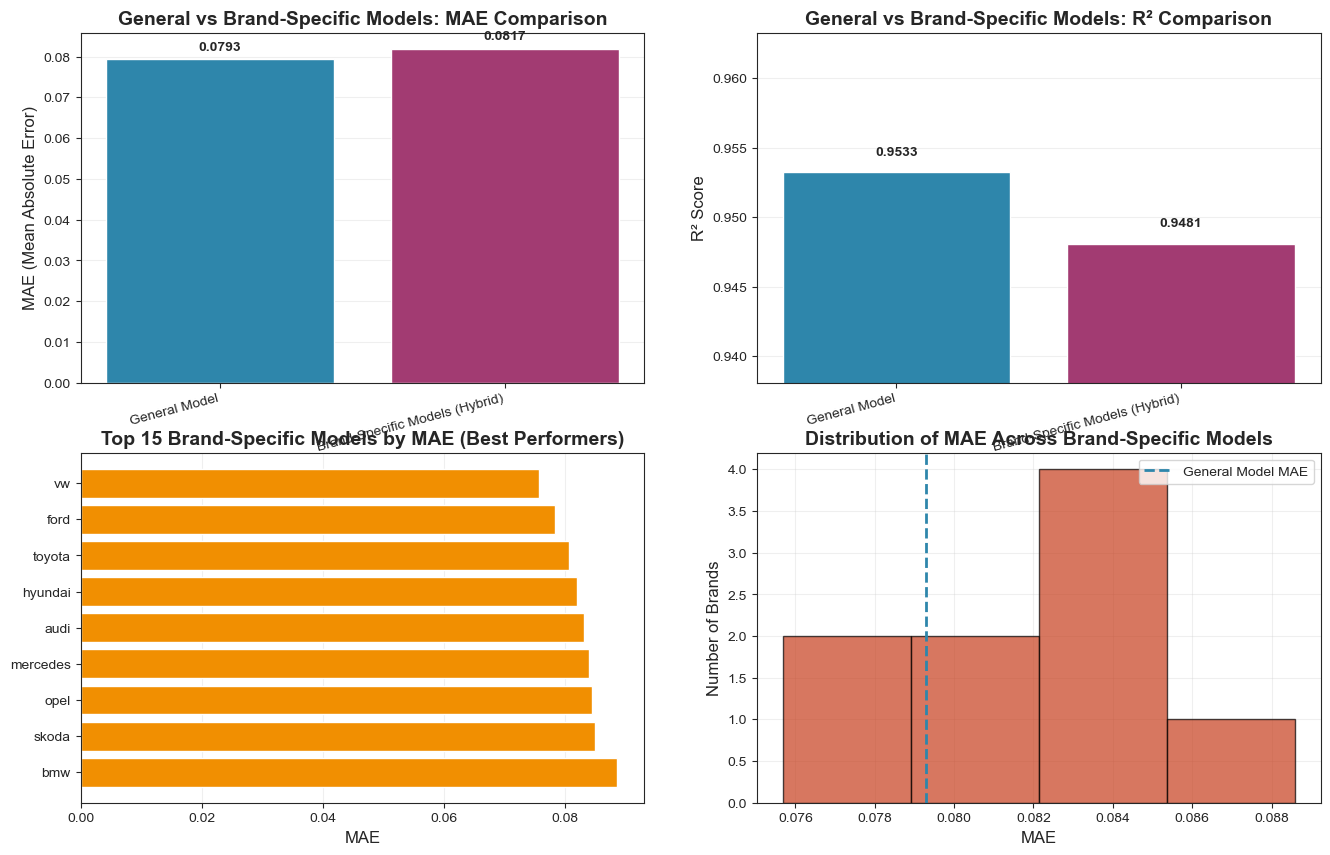


TRAINING MODEL-SPECIFIC MODELS

Models in training data: 168
Filtering models with at least 30 samples...
Valid models for specific models: 116
  focus                         : ERROR - could not convert string to float: 'ford'
  clclass                       : ERROR - could not convert string to float: 'mercedes'
  fiesta                        : ERROR - could not convert string to float: 'ford'
  golfsv                        : ERROR - could not convert string to float: 'vw'
  corsa                         : ERROR - could not convert string to float: 'opel'
  polo                          : ERROR - could not convert string to float: 'vw'
  claclass                      : ERROR - could not convert string to float: 'mercedes'
  mokka                         : ERROR - could not convert string to float: 'opel'
  astra                         : ERROR - could not convert string to float: 'opel'
  series3                       : ERROR - could not convert string to float: 'bmw'
  kuga      

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:


# ============================================================================
# MAIN EXECUTION WORKFLOW
# ============================================================================



# STEP 2: Train general model (WITHOUT brand column)
general_model, gen_train_metrics, gen_val_metrics = train_general_model(
    X_train_selected,  # NO brand column (encoded features only)
    y_train_log, 
    X_val_selected,    # NO brand column
    y_val_log
)

# STEP 3: Train brand-specific models (WITH brand column to filter by)
brand_models, brand_metrics_df = train_brand_specific_models(
    X_train_with_brand,  # WITH brand column
    y_train_log, 
    X_val_with_brand,    # WITH brand column
    y_val_log,
    brand_column='Brand',
    min_samples=50,
    apply_scaling=False  # No scaling needed for tree-based models
)

# STEP 4: Compare approaches
comparison_df = compare_approaches(
    general_model, 
    brand_models, 
    X_train_with_brand,  # WITH brand
    X_val_with_brand,    # WITH brand
    y_train_log, 
    y_val_log,
    brand_column='Brand',
    general_model_has_brand=False  # General model was trained WITHOUT brand
)

# STEP 5: Detailed brand analysis
brand_comparison_df = detailed_brand_analysis(
    general_model, 
    brand_models, 
    X_val_with_brand,  # WITH brand
    y_val_log,
    brand_column='Brand',
    general_model_has_brand=False  # General model was trained WITHOUT brand
)

# STEP 6: Visualize results
visualize_comparison(comparison_df, brand_metrics_df)

# STEP 7: Optional - Train model-specific models
model_specific, model_metrics_df = train_model_specific_models(
    X_train_with_brand_with_model,  # WITH brand and model columns
    y_train_log,
    X_val_with_brand_with_model,    # WITH brand and model columns
    y_val_log,
    model_column='model',  
    min_samples=30
)

# STEP 8: Save results
comparison_df.to_csv('general_vs_specific_comparison.csv', index=False)
brand_comparison_df.to_csv('brand_by_brand_comparison.csv', index=False)



In [67]:

print("ANALYSIS COMPLETE!")

print(f"General Model Val MAE: {comparison_df[comparison_df['label']=='General Model']['mae'].values[0]:.2f}")
print(f"Brand-Specific Combined Val MAE: {comparison_df[comparison_df['label']=='Brand-Specific Models']['mae'].values[0]:.2f}")


ANALYSIS COMPLETE!
General Model Val MAE: 0.08


IndexError: index 0 is out of bounds for axis 0 with size 0